# Lexicométrie par requêtes dans le cahiers

In [1]:
import re
import csv
import spacy
from collections import defaultdict, Counter
from vega import VegaLite

In [2]:
nlp = spacy.load('fr_core_news_lg')

In [3]:
with open('./resources/cahiers.csv') as f:
    data = list(csv.DictReader(f))

In [4]:
# Parsing sentences
for item in data:
    doc = nlp(item['texte_cahier_txt'])
    item['doc'] = doc
    item['sentences'] = [str(sent) for sent in doc.sents]

## Requêtes

In [5]:
QUERIES = [
    {
        'name': 'sel',
        'pattern': r'\bgabelles?\b|\bsauniers?\b|\bsalin|\bsels?\b',
        'flags': re.I
    },
    {
        'name': 'angleterre',
        'pattern': r'\bAngleterre\b|\b[Bb]ritann?ique|\b[Aa]ngl[ao]|\bEden\b'
    },
    {
        'name': 'produits_coloniaux',
        'pattern': r'\bcaf[ée]s?\b|\bsucres?\b|\bindigo|\btabac',
        'flags': re.I
    },
    {
        'name': 'traite_negriere',
        'pattern': r'\b[Nn][èeé]gr|\b[Aa]fri' # NOTE: ceci ne marche pas, on ne matche que des noms propres
    },
    {
        'name': 'la_rochelle',
        'pattern': r'rochelle\b',
        'flags': re.I
    },
    {
        'name': 'alcool',
        'pattern': r'\balcool|\bvins?\b|\beaux?[\-—\s]+de[\-—\s]+vie',
        'flags': re.I
    },
    {
        'name': 'navigation',
        'pattern': r'\bnavi[rg]|\bports?\b|\bcabot(?:age|eur)s?\b|\bmatt?elots?\b|\bnaufrag',
        'flags': re.I
    },
    {
        'name': 'etranger',
        'pattern': r'[\bl][eé]s?tranger|\bexport|\bimports?\b|\bimportations?\b|\bentrep[oô]', # NOTE: "importe" est problématique à cause de la polysémie avec "importance"
        'flags': re.I
    },
    {
        'name': 'petites_iles',
        'pattern': r'\bBouin\b|\bNoirmoutiers?'
    },
    {
        'name': 'commerce_colonial',
        'pattern': r'\b[Cc]coloni|\b[Aa]m[ée]ri[cq]|\bIsles\b|\bMartini[cq]|\bGuadeloupe|Domingue\b|[iî]s?les?\s+Bourbon|[iî]s?les?\s+de\s+France\b|\bGuyen|\bAntilles'
    },
    {
        'name': 'provinces',
        'pattern': r'\bBretagne|\bNormandie|\bPicardie|\bFlandre',
        'flags': re.I
    },
    {
        'name': 'institutions',
        'pattern': r'\b(chambre|conseil)\s+de\s+commerce|\bamiraut',
        'flags': re.I
    },
    {
        'name': 'ferme_generale',
        'pattern': r'\bferm[iea]|\bcomm?is\b|\bacquits?\b|\btarifs?\b'
    },
    {
        'name': 'contole_etatique',
        'pattern': r'\bclasses?\b|\bgarde[\-—\s]+c[oô]t',
        'flags': re.I
    },
    {
        'name': 'peche',
        'pattern': r'\bTerre[\-—\s]+Neuve|\bmorues?\b|\bpoissons?\b|\bsardines?|\bhu[îi]tres?\b|\bmoules?\b|\bp[êe]che',
        'flags': re.I
    },
    {
        'name': 'calamites',
        'pattern': r'\bfamines?\b|\baffam?mé|\bdisette|\bravage|\bvimer|\bmalad\b|\bd[ée]g[aâ]t|\bd[eé]bordement',
        'flags': re.I
    },
    {
        'name': 'cereales',
        'pattern': r'\bbl[ée]ds?\b|\bbl[ée]s?\b|\bfr[uo]ment|\bvivres?\b',
        'flags': re.I
    }
]

for q in QUERIES:
    if 'flags' in q:
        q['pattern'] = re.compile(q['pattern'], q['flags'])
    else:
        q['pattern'] = re.compile(q['pattern'])

## Calcul des statistiques

In [6]:
counts = Counter(item['rural_littoral'] for item in data)
counts

Counter({'rural': 124, 'littoral': 26, '': 13})

In [7]:
sents_counts = Counter()

for item in data:
    sents_counts[item['rural_littoral']] += len(item['sentences'])
sents_counts

Counter({'rural': 14388, 'littoral': 3944, '': 2607})

In [16]:
queries_matches_counts = defaultdict(Counter)
queries_sents_counts = defaultdict(Counter)
queries_counts = defaultdict(Counter)
verbatims = defaultdict(lambda: defaultdict(list))

for item in data:
    
    # NOTE: certains cahier ne sont pas pas catégorisés (facile à ajouter)
    if not item['rural_littoral']:
        continue
        
    typ = item['rural_littoral']
    
    for query in QUERIES:
        matched = False
        
        matches = query['pattern'].findall(item['texte_cahier_txt'])
        
        if matches:
            queries_matches_counts[typ][query['name']] += len(matches)
            matched = True
            
        for sent in item['sentences']:
            if query['pattern'].search(sent):
                queries_sents_counts[typ][query['name']] += 1
                verbatims[typ][query['name']].append((item, sent))
        
        if matched:
            queries_counts[typ][query['name']] += 1
            
queries_counts, queries_matches_counts, queries_sents_counts

(defaultdict(collections.Counter,
             {'rural': Counter({'la_rochelle': 12,
                       'commerce_colonial': 6,
                       'ferme_generale': 91,
                       'calamites': 13,
                       'cereales': 33,
                       'contole_etatique': 35,
                       'alcool': 40,
                       'sel': 20,
                       'produits_coloniaux': 10,
                       'etranger': 6,
                       'provinces': 1,
                       'navigation': 14,
                       'angleterre': 6,
                       'institutions': 1,
                       'peche': 1,
                       'traite_negriere': 2,
                       'petites_iles': 1}),
              'littoral': Counter({'sel': 16,
                       'navigation': 15,
                       'provinces': 7,
                       'etranger': 8,
                       'institutions': 11,
                       'peche': 9,
           

## Visualisations

In [9]:
queries_sents_ratios = defaultdict(Counter)
queries_ratios = defaultdict(Counter)

for typ, container in queries_counts.items():
    for k, c in container.items():
        queries_ratios[typ][k] = c / counts[typ]
        
for typ, container in queries_sents_counts.items():
    for k, c in container.items():
        queries_sents_ratios[typ][k] = c / sents_counts[typ]

In [10]:
queries_sents_ratios

defaultdict(collections.Counter,
            {'rural': Counter({'la_rochelle': 0.0008340283569641367,
                      'commerce_colonial': 0.0007645259938837921,
                      'ferme_generale': 0.016958576591604116,
                      'calamites': 0.001042535446205171,
                      'cereales': 0.003197108701695858,
                      'contole_etatique': 0.004448151237142063,
                      'alcool': 0.005699193772588268,
                      'sel': 0.002085070892410342,
                      'produits_coloniaux': 0.0009035307200444815,
                      'etranger': 0.0004170141784820684,
                      'provinces': 6.950236308034473e-05,
                      'navigation': 0.0017375590770086183,
                      'angleterre': 0.0004170141784820684,
                      'institutions': 6.950236308034473e-05,
                      'peche': 6.950236308034473e-05,
                      'traite_negriere': 0.00013900472616068947,
        

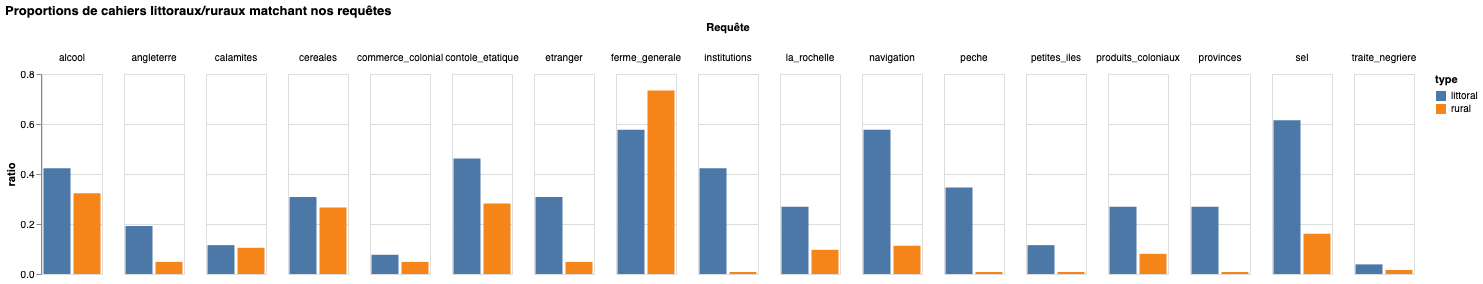

In [11]:
per_cahier_viz_data = []

for typ, container in queries_ratios.items():
    for q, r in container.items():
        per_cahier_viz_data.append({
            'type': typ,
            'query': q,
            'ratio': r
        })
        
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Proportions de cahiers littoraux/ruraux matchant nos requêtes",
    "mark": "bar",
    "width": {"step": 30},
    "encoding": {
        "x": {
            "field": "type",
            "type": "nominal",
            "axis": ""
        },
        "y": {
            "type": "quantitative",
            "field": "ratio"
        },
        "color": {
            "type": "nominal",
            "field": "type"
        },
        "column": {
            "type": "nominal",
            "field": "query",
            "title": "Requête"
        }
    }
}, per_cahier_viz_data)

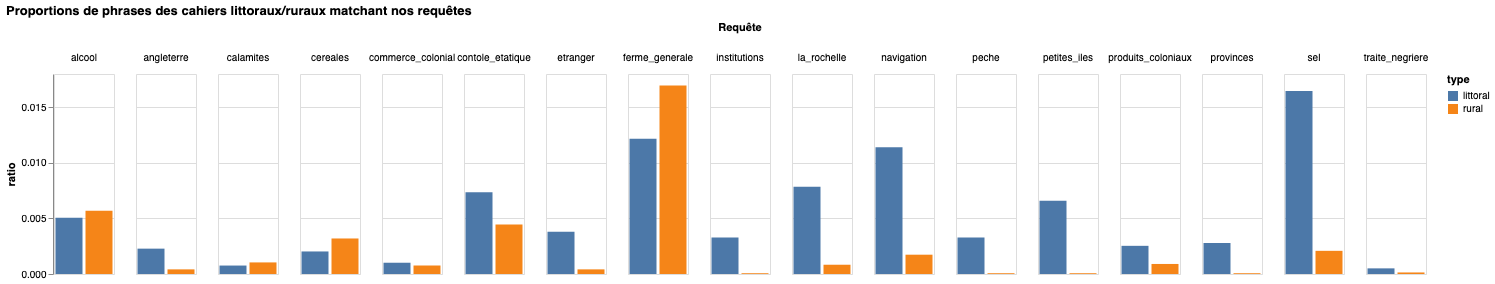

In [12]:
per_sent_viz_data = []

for typ, container in queries_sents_ratios.items():
    for q, r in container.items():
        per_sent_viz_data.append({
            'type': typ,
            'query': q,
            'ratio': r
        })
        
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Proportions de phrases des cahiers littoraux/ruraux matchant nos requêtes",
    "mark": "bar",
    "width": {"step": 30},
    "encoding": {
        "x": {
            "field": "type",
            "type": "nominal",
            "axis": ""
        },
        "y": {
            "type": "quantitative",
            "field": "ratio"
        },
        "color": {
            "type": "nominal",
            "field": "type"
        },
        "column": {
            "type": "nominal",
            "field": "query",
            "title": "Requête"
        }
    }
}, per_sent_viz_data)

In [17]:
for _, sent in verbatims['rural']['etranger']:
    print(sent)
    print()
    print()

Ces institutions lèzent le bien général de l’état, soit en empêchant une égale répartition du commerce dans l’étendue du Royaume, soit en le gènant en plusieurs endroits ainsi que les exportations et importations, soit en décourageant l’agriculture, soit en dévastant la campagne de leurs cultivateurs, qui séduits par l’apas de la fortune, abbandonnent bientôt l’état simple et rustique de leurs pères pour se revétir de celui d’un employé.


Les entrepôts du tabac offrent surtout un abus intolérable, la ferme générale, indifférente sur les infidélités nuisibles qui altèrent ou vicient la qualité du tabac en poudre, confie indistinctement ce poste à la recommandation des seigneurs qui, communément, en font le lot de leurs commensaux.


Il faudrait donc supprimer ou tout au moins reculer aux frontières les bureaux de traites, péages, octrois et aides, et supprimer tous droits sur les denrées et marchandises d’exportation [et] de tous objets, même venant de l’étranger.


Il faudrait donc su

## Export des verbatims

In [18]:
with open('./outputs/verbatims.csv', 'w') as f:
    writer = csv.DictWriter(f, fieldnames=['titre', 'localite', 'rural_littoral', 'query', 'verbatim'])
    writer.writeheader()
    
    for typ, container in verbatims.items():
        for query, tuples in container.items():
            for item, sent in tuples:
                writer.writerow({
                    'titre': item['titre_propre'],
                    'localite': item['localite'],
                    'rural_littoral': typ,
                    'query': query,
                    'verbatim': sent
                })